C:\Users\Logan\AppData\Local\Temp\ipykernel_47652\3846259263.py:230: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=45)


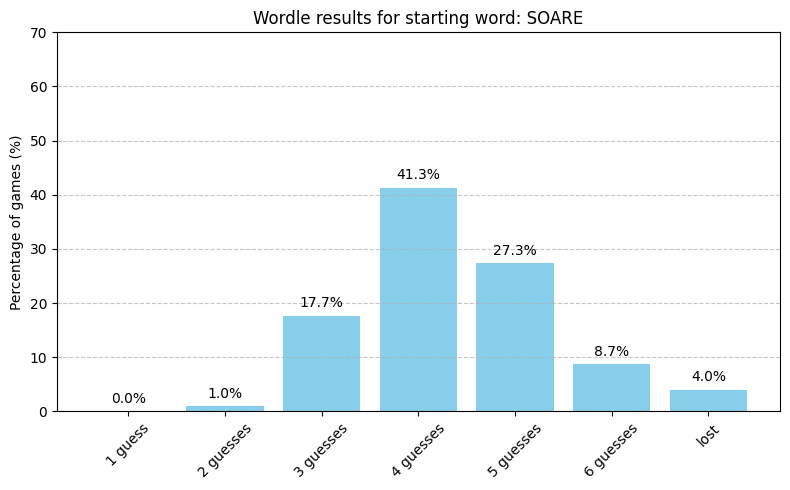

C:\Users\Logan\AppData\Local\Temp\ipykernel_47652\3846259263.py:230: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=45)


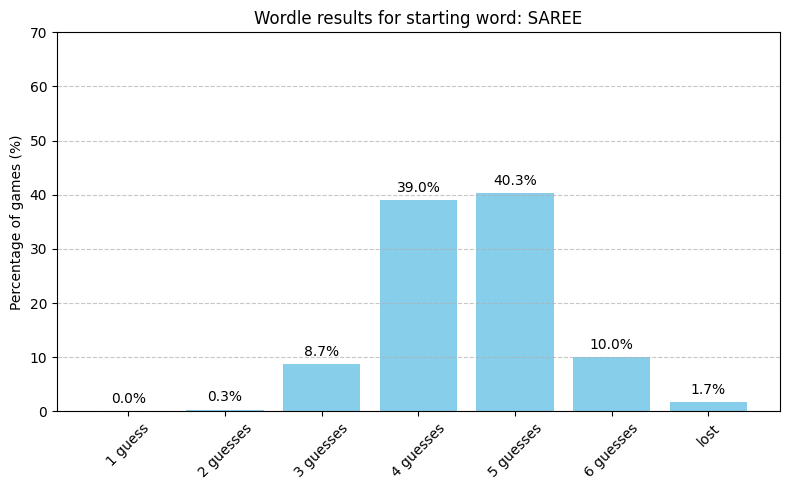

C:\Users\Logan\AppData\Local\Temp\ipykernel_47652\3846259263.py:230: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=45)


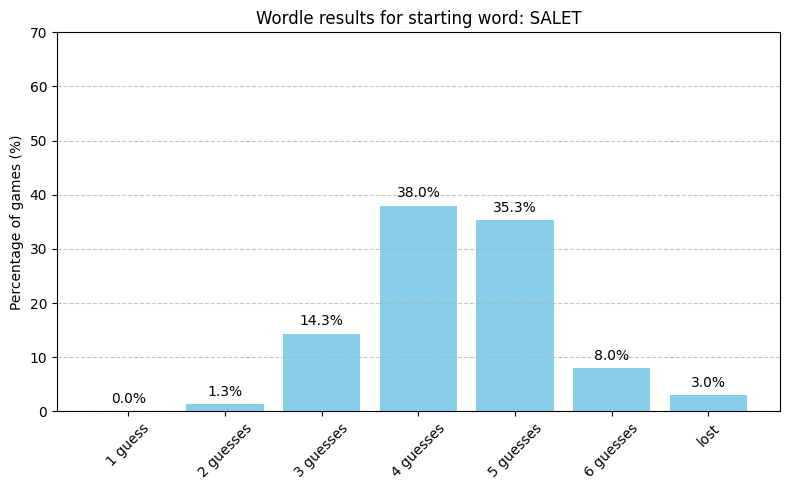

C:\Users\Logan\AppData\Local\Temp\ipykernel_47652\3846259263.py:230: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=45)


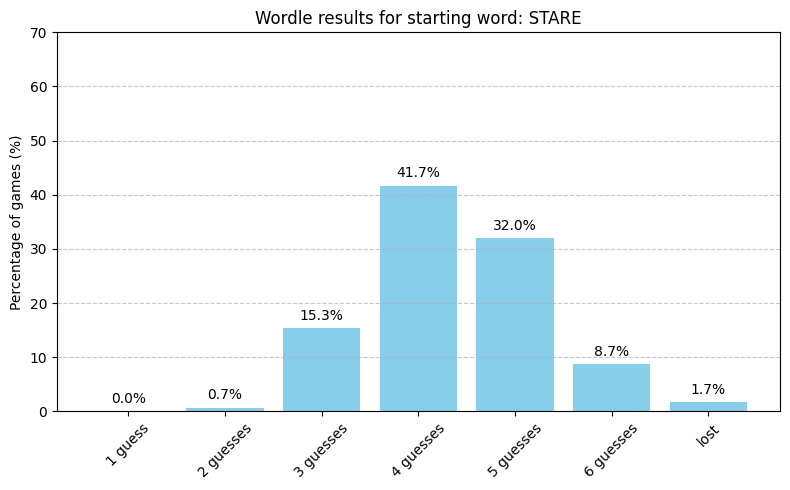

C:\Users\Logan\AppData\Local\Temp\ipykernel_47652\3846259263.py:230: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=45)


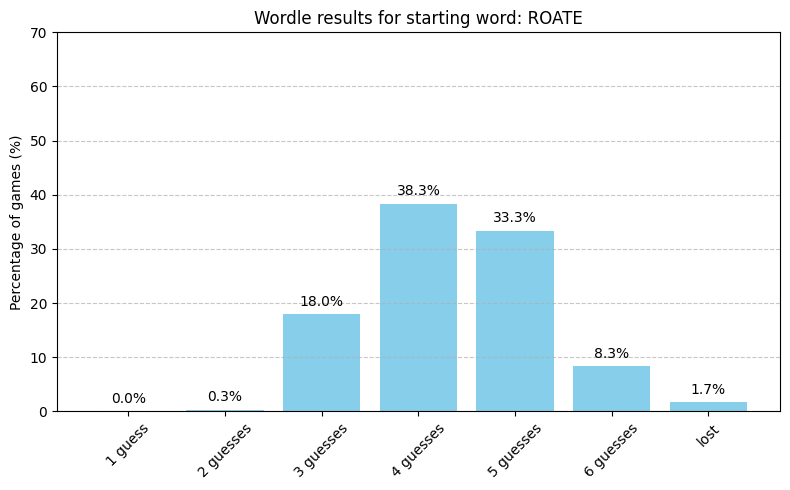

In [ ]:
import matplotlib.pyplot as plt
import random

"""
A simple Wordle emulator in Python.
You can manually set the SECRET_WORD to define what the answer should be.
"""
import string
from word_lists import get_target
from word_lists import is_valid_guess
from pruning import wordlePrune, infoPrune

class Guesser:
    def make_guess(self, attempt, solutions_list, information_list, letter_status):
        if attempt == 1:
            return "SALET"
        
        # If narrowing down to few solutions, prioritize that
        if len(solutions_list) <= (7 - attempt):
            return solutions_list[-1]

        guessed_letters = {
            L for L, status in letter_status.items() if status["state"] != "not_guessed"
        }

        yellow_letters = {
            L for L, status in letter_status.items() if status["state"] == "in_wrong_place"
        }

        def sort_key(word):
            unique = set(word)
            unguessed_count = sum(1 for c in unique if c not in guessed_letters)
            has_yellow = any(c in yellow_letters for c in word)
            return (-unguessed_count, -has_yellow)

        sorted_words = sorted(information_list, key=sort_key)

        if len(information_list) == 0:
            return solutions_list[-1]

        top_choices = sorted_words[:5] if len(sorted_words) >= 5 else sorted_words
        return random.choice(top_choices)

SECRET_WORD = get_target()
guesser = Guesser()

def initialize_letter_status():
    """
    Creates a dict of all letters
    """
    # ─── initialization ───────────────────────────────────────────────
    return {
        ch: {"state": "not_guessed",
            "green": set(),           # positions confirmed green
            "yellow": set()}          # positions where it is NOT allowed
        for ch in string.ascii_uppercase
    }



def wordle_feedback_for_guess(guess: str, solution: str):
    """
    Evaluate one Wordle guess.

    Returns
    -------
    in_right_place : list[(idx, letter)]
    in_wrong_place : list[(idx, letter)]
    not_in_word    : list[letter]               # sorted, no dups
    guess_colors   : str                        # e.g. "GGBYB"
        For each index i:
            G → green  (correct letter, correct spot)
            Y → yellow (correct letter, wrong spot)
            B → black/gray (letter not in word)
    written with assistance of ChatGPT-o3
    """
    guess = guess.upper()
    solution = solution.upper()
    colors = ["B"] * 5                # default everything to gray/black
    sol_chars = list(solution)
    used      = [False] * 5           # which letters of solution already matched


    in_right_place = []
    in_wrong_place = []
    not_in_word_set = set()

    # Track used letters in solution to avoid reusing them
    used = [False] * 5

    # Pass 1 – exact matches → GREEN
    for i in range(5):
        if guess[i] == sol_chars[i]:
            colors[i] = "G"
            in_right_place.append((i, guess[i]))
            used[i] = True

    # Pass 2 – wrong‑place matches → YELLOW or still B
    for i in range(5):
        if colors[i] == "G":
            continue                  # already handled
        found = False
        for j in range(5):
            if not used[j] and guess[i] == sol_chars[j]:
                # letter exists elsewhere and not consumed yet
                colors[i] = "Y"
                in_wrong_place.append((i, guess[i]))
                used[j] = True
                found = True
                break
        if not found:
            not_in_word_set.add(guess[i])

    return (
        in_right_place,
        in_wrong_place,
        sorted(not_in_word_set),
        "".join(colors),
    )


def categorize_global(letter_status):
    greens, yellows, grays, untried = [], [], [], []

    for L, entry in letter_status.items():
        st    = entry["state"]
        green = sorted(entry["green"])
        yel   = sorted(entry["yellow"])

        if st == "in_right_place":
            greens.append((L, green))      # list indices that ARE green
        elif st == "in_wrong_place":
            yellows.append((L, yel))       # list indices that CANNOT be yellow
        elif st == "not_in_word":
            grays.append(L)
        else:
            untried.append(L)

    greens.sort(key=lambda t: t[0])
    yellows.sort(key=lambda t: t[0])
    grays.sort()
    untried.sort()
    return greens, yellows, grays, untried

with open("wordle_possibles.txt") as f:
    POSSIBLES = [w.strip().upper() for w in f]
with open("wordle_targets.txt") as f:
    TARGETS = [w.strip().upper() for w in f]

ALL_WORDS = POSSIBLES + TARGETS          # 25 k-ish, stays in RAM
T        = len(TARGETS)                  # games per starting word

def simulate_wordle_game(starting_word, secret_word):
    guesser = Guesser()
    letter_status = initialize_letter_status()

    # Fresh copies for this one game
    solutions_list = ALL_WORDS.copy()
    information_list = ALL_WORDS.copy()

    max_guesses = 6
    for attempt in range(1, max_guesses + 1):
        if attempt == 1:
            guess = starting_word
        else:
            guess = guesser.make_guess(attempt, solutions_list, information_list, letter_status)

        # Get feedback
        (
            guess_in_right_place,
            guess_in_wrong_place,
            guess_not_in_word,
            guess_colors,
        ) = wordle_feedback_for_guess(guess, secret_word)

        # Update pruning
        solutions_list = wordlePrune(guess, solutions_list, guess_colors)
        information_list = infoPrune(guess, information_list, guess_colors)

        # Update letter_status
        for idx, L in guess_in_right_place:
            letter_status[L]["state"] = "in_right_place"
            letter_status[L]["green"].add(idx)
        for idx, L in guess_in_wrong_place:
            letter_status[L]["yellow"].add(idx)
            if letter_status[L]["state"] != "in_right_place":
                letter_status[L]["state"] = "in_wrong_place"
        for L in guess_not_in_word:
            if letter_status[L]["state"] == "not_guessed":
                letter_status[L]["state"] = "not_in_word"

        if guess == secret_word:
            return attempt  # return number of guesses

    return 7  # 7 means failure (loss)

starting_words = ["SOARE", "SAREE", "SALET", "STARE", "ROATE"]
num_simulations = 300

# Initialize results storage
results = {word: {i: 0 for i in range(1, 8)} for word in starting_words}
# 1-6 for wins, 7 for losses

for starting_word in starting_words:
    for _ in range(num_simulations):
        # pick a random secret word from target list
        with open('wordle_targets.txt', 'r') as file:
            targets = [line.strip().upper() for line in file.readlines()]
        secret_word = random.choice(targets)

        attempts = simulate_wordle_game(starting_word, secret_word)
        results[starting_word][attempts] += 1

# Now plot
for starting_word in starting_words:
    counts = [results[starting_word][i] for i in range(1, 8)]

    # Set up figure and axis
    fig, ax = plt.subplots(figsize=(8, 5))
    
    labels = ["1 guess", "2 guesses", "3 guesses", "4 guesses", "5 guesses", "6 guesses", "lost"]
    percentages = [c / num_simulations * 100 for c in counts]
    
    bars = ax.bar(labels, percentages, color='skyblue')

    # Add labels
    ax.set_title(f"Wordle results for starting word: {starting_word}")
    ax.set_ylabel("Percentage of games (%)")
    ax.set_ylim(0, 70)
    ax.set_xticklabels(labels, rotation=45)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    # Add percentages above bars
    for bar, percent in zip(bars, percentages):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height + 1, 
                f'{percent:.1f}%', ha='center', va='bottom', fontsize=10)

    plt.tight_layout()
    plt.show()


Extra Test: Goes thru whole solutions list instead of randomly

C:\Users\Logan\AppData\Local\Temp\ipykernel_47652\217877953.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=45)


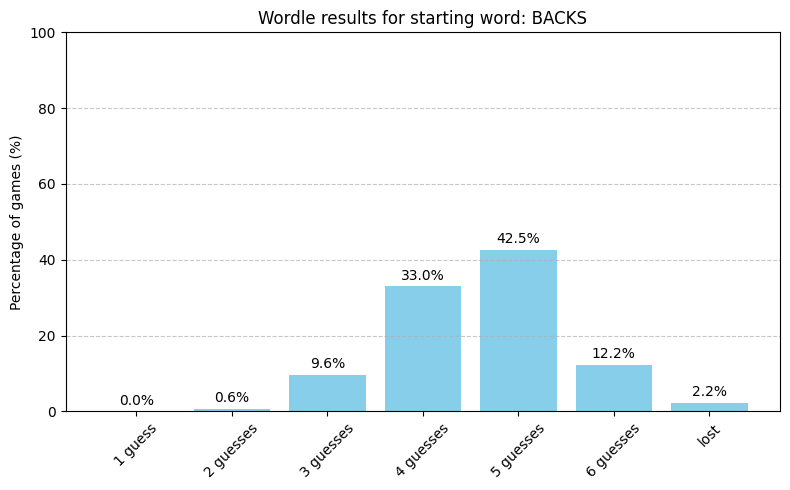

In [ ]:
starting_words = ["BACKS"]

# Initialize results storage
results = {word: {i: 0 for i in range(1, 8)} for word in starting_words}
# 1-6 for wins, 7 for losses

with open('wordle_targets.txt', 'r') as file:
    targets = [line.strip().upper() for line in file.readlines()]

num_simulations = len(targets)

for starting_word in starting_words:
    for target in targets:
        secret_word = target

        attempts = simulate_wordle_game(starting_word, secret_word)
        results[starting_word][attempts] += 1

# Now plot
for starting_word in starting_words:
    counts = [results[starting_word][i] for i in range(1, 8)]

    # Set up figure and axis
    fig, ax = plt.subplots(figsize=(8, 5))
    
    labels = ["1 guess", "2 guesses", "3 guesses", "4 guesses", "5 guesses", "6 guesses", "lost"]
    percentages = [c / num_simulations * 100 for c in counts]
    
    bars = ax.bar(labels, percentages, color='skyblue')

    # Add labels
    ax.set_title(f"Wordle results for starting word: {starting_word}")
    ax.set_ylabel("Percentage of games (%)")
    ax.set_ylim(0, 100)
    ax.set_xticklabels(labels, rotation=45)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    # Add percentages above bars
    for bar, percent in zip(bars, percentages):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height + 1, 
                f'{percent:.1f}%', ha='center', va='bottom', fontsize=10)

    plt.tight_layout()
    plt.show()

Extra Test: Every possible and target tested on whole solutions dataset (do not run unless you have a good computer). This gives the top 10 best words in Wordle using our parameters.